# Am I feeding my network crap

Given that my research on the image content of optical flow images shows such huge variety is my image generation doing  anything useful to it??? Perhaps experiment with a very small network for say only 10 classes?? 

First lets look at the output for something relatively easy like cricket 

In [1]:
import os
import sys


up1 = os.path.abspath('../../utils/') 
up2 = os.path.abspath('../../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow
from motion_network import getKerasCifarMotionModel2, getKerasCifarMotionModelOnly
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.optimizers import SGD
import cv2 
import numpy as np


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Is it the data or my classifier

I am starting to wonder what it is about my optical flow data that might be causing so much easier. Regardless about the unconverged flow images I feel the author of the data still managed with it. So there's essentially two things I can either get a large amount of improvement simply on how I train my classifier (slower?), or my data set is not quite right. I've already seen that I wasn't even doing any random transforms on my opt flow images courtesy my badly written opt flow data generator. 
Any how what I am aiming to do is use a stinkingly cheap data model to explore what might be wrong. 

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.initializers import Ones
from keras import optimizers

def getModel(lr=1e-2):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('sigmoid'))

    optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [4]:
model_fast_lr = getModel(lr=1e-4)

In [4]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow

training_options = { 'rescale' : 1./255, 
                            'shear_range' : 0.2, 
                            'zoom_range' : 0.2, 
                            'horizontal_flip' : True,
                             'rotation_range':20,
                             'width_shift_range':0.2,
                             'height_shift_range':0.2}

validation_options = { 'rescale' : 1./255 }




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 64,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 10,
           'validation' : False}

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size':64,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 10,
           'validation' : True}

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01_small.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01_small.txt', \
                       '../../data/ucf101_splits/classInd_small.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [15]:
mod1 = model_fast_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=50,
                    verbose=1)

Epoch 1/50
64/64 [==============================] - 39s 613ms/step - loss: 2.2698 - acc: 0.1316 - val_loss: 2.2504 - val_acc: 0.1575
Epoch 2/50
64/64 [==============================] - 34s 539ms/step - loss: 2.2207 - acc: 0.1746 - val_loss: 2.2031 - val_acc: 0.1953
Epoch 3/50
64/64 [==============================] - 36s 568ms/step - loss: 2.1723 - acc: 0.2234 - val_loss: 2.1443 - val_acc: 0.2695
Epoch 4/50
64/64 [==============================] - 38s 593ms/step - loss: 2.1123 - acc: 0.2705 - val_loss: 2.1225 - val_acc: 0.2676
Epoch 5/50
64/64 [==============================] - 34s 533ms/step - loss: 2.0839 - acc: 0.2866 - val_loss: 2.0952 - val_acc: 0.3008
Epoch 6/50
64/64 [==============================] - 34s 533ms/step - loss: 2.0549 - acc: 0.2786 - val_loss: 2.0538 - val_acc: 0.3074
Epoch 7/50
64/64 [==============================] - 32s 500ms/step - loss: 1.9815 - acc: 0.3086 - val_loss: 2.0219 - val_acc: 0.3171
Epoch 8/50
64/64 [==============================] - 34s 538ms/step - 

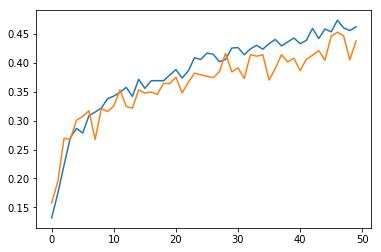

In [20]:
plt.plot(mod1.history['acc'])
plt.plot(mod1.history['val_acc'])

In [22]:
mod2 = model_fast_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
64/64 [==============================] - 28s 444ms/step - loss: 1.5202 - acc: 0.4705 - val_loss: 1.7185 - val_acc: 0.4272
Epoch 2/20
64/64 [==============================] - 26s 404ms/step - loss: 1.5222 - acc: 0.4795 - val_loss: 1.6620 - val_acc: 0.4624
Epoch 3/20
64/64 [==============================] - 28s 444ms/step - loss: 1.4845 - acc: 0.4902 - val_loss: 1.7207 - val_acc: 0.4424
Epoch 4/20
64/64 [==============================] - 28s 437ms/step - loss: 1.5069 - acc: 0.4939 - val_loss: 1.6602 - val_acc: 0.4382
Epoch 5/20
64/64 [==============================] - 28s 433ms/step - loss: 1.4981 - acc: 0.4946 - val_loss: 1.6323 - val_acc: 0.4485
Epoch 6/20
64/64 [==============================] - 28s 431ms/step - loss: 1.4747 - acc: 0.5000 - val_loss: 1.6657 - val_acc: 0.4531
Epoch 7/20
64/64 [==============================] - 26s 404ms/step - loss: 1.4796 - acc: 0.5037 - val_loss: 1.6763 - val_acc: 0.4661
Epoch 8/20
64/64 [==============================] - 27s 428ms/step - 

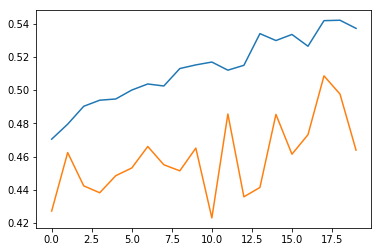

In [23]:
plt.plot(mod2.history['acc'])
plt.plot(mod2.history['val_acc'])

In [24]:
model_fast_lr.save_weights('../../data/weights/model_slow_lr_big_batch.hdf5')

In [25]:
mod3 = model_fast_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=50,
                    verbose=1)

Epoch 1/50
64/64 [==============================] - 27s 427ms/step - loss: 1.3474 - acc: 0.5393 - val_loss: 1.6043 - val_acc: 0.4961
Epoch 2/50
64/64 [==============================] - 27s 417ms/step - loss: 1.3589 - acc: 0.5447 - val_loss: 1.5808 - val_acc: 0.4768
Epoch 3/50
64/64 [==============================] - 26s 399ms/step - loss: 1.3513 - acc: 0.5452 - val_loss: 1.5626 - val_acc: 0.4700
Epoch 4/50
64/64 [==============================] - 28s 430ms/step - loss: 1.3422 - acc: 0.5403 - val_loss: 1.5262 - val_acc: 0.4978
Epoch 5/50
64/64 [==============================] - 28s 433ms/step - loss: 1.3432 - acc: 0.5500 - val_loss: 1.6045 - val_acc: 0.4800
Epoch 6/50
64/64 [==============================] - 26s 408ms/step - loss: 1.3173 - acc: 0.5449 - val_loss: 1.5146 - val_acc: 0.5078
Epoch 7/50
64/64 [==============================] - 26s 401ms/step - loss: 1.3386 - acc: 0.5432 - val_loss: 1.5653 - val_acc: 0.4902
Epoch 8/50
64/64 [==============================] - 28s 431ms/step - 

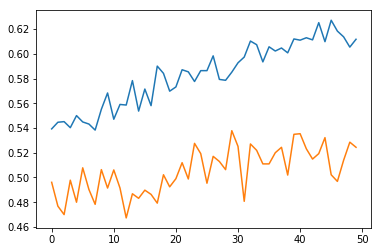

In [26]:
plt.plot(mod3.history['acc'])
plt.plot(mod3.history['val_acc'])

In [27]:
model_fast_lr.save_weights('../../data/weights/model_slow_lr_big_batch.hdf5')

In [28]:
mod4 = model_fast_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=30,
                    verbose=1)

Epoch 1/30
64/64 [==============================] - 27s 419ms/step - loss: 1.1064 - acc: 0.6196 - val_loss: 1.5142 - val_acc: 0.5273
Epoch 2/30
64/64 [==============================] - 25s 391ms/step - loss: 1.1164 - acc: 0.6184 - val_loss: 1.5017 - val_acc: 0.5266
Epoch 3/30
64/64 [==============================] - 26s 400ms/step - loss: 1.1375 - acc: 0.6169 - val_loss: 1.4519 - val_acc: 0.5122
Epoch 4/30
64/64 [==============================] - 26s 408ms/step - loss: 1.0954 - acc: 0.6292 - val_loss: 1.5010 - val_acc: 0.5227
Epoch 5/30
64/64 [==============================] - 25s 393ms/step - loss: 1.0938 - acc: 0.6245 - val_loss: 1.4880 - val_acc: 0.5327
Epoch 6/30
64/64 [==============================] - 25s 395ms/step - loss: 1.0890 - acc: 0.6272 - val_loss: 1.4573 - val_acc: 0.5249
Epoch 7/30
64/64 [==============================] - 25s 394ms/step - loss: 1.0916 - acc: 0.6304 - val_loss: 1.4469 - val_acc: 0.5344
Epoch 8/30
64/64 [==============================] - 27s 421ms/step - 

In [29]:
model_fast_lr.save_weights('../../data/weights/model_slow_lr_big_batch.hdf5')

## Good model!

    Unsurprisingly the accuracy of this model is a lot better, but I think its fair to say training low number class model is easier than a high number class model. My feeling is I could probably get to 60% with this model. Over fitting starts to set in further down the line. I wonder what the simonyan model would make of this. 

I wonder how much what the diversity in classes looks like per batch. Is it equally weighted??

In [21]:
_X = None
_y = None

for i, (X, y) in enumerate(training_generator):
    _X = X
    _y = y
    if i > 10:
        break

In [22]:
_y.sum(axis=0)

array([ 7.,  2.,  5.,  7.,  7., 11.,  8.,  5.,  6.,  6.])

In [29]:

params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 256,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 101,
           'validation' : False}

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01.txt')
training_generator = DataGenerator(*id_labels_train, **params_train)



In [34]:
_X = None
_y = None

for i, (X, y) in enumerate(training_generator):
    _X = X
    _y = y
    if i > 3:
        break

In [35]:
_y.sum(axis=0)

array([2., 1., 3., 3., 2., 2., 5., 3., 1., 4., 1., 6., 3., 3., 3., 0., 3.,
       6., 0., 4., 3., 3., 1., 2., 2., 4., 2., 1., 3., 4., 1., 2., 3., 4.,
       3., 1., 2., 3., 4., 4., 2., 3., 2., 6., 0., 3., 3., 1., 2., 3., 5.,
       1., 3., 3., 2., 1., 2., 0., 4., 3., 2., 6., 3., 5., 2., 2., 4., 2.,
       4., 1., 3., 0., 1., 4., 2., 2., 3., 3., 4., 0., 1., 3., 2., 1., 2.,
       3., 2., 2., 3., 3., 1., 4., 1., 4., 1., 4., 4., 1., 0., 4., 1.])

# Data augmentation 

lets enable data augmentation  and see if we can nick a few more percentage points quickly. 

In [5]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow

training_options = { 'rescale' : 1./255, 
                            'shear_range' : 0.2, 
                            'zoom_range' : 0.2, 
                            'horizontal_flip' : True,
                             'rotation_range':20,
                             'width_shift_range':0.2,
                             'height_shift_range':0.2}

validation_options = { 'rescale' : 1./255 }




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 64,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'enable_augmentation':True,
                'n_classes' : 10,
           'validation' : False}

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size':64,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'enable_augmentation':True,
                'n_classes' : 10,
           'validation' : True}

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01_small.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01_small.txt', \
                       '../../data/ucf101_splits/classInd_small.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [7]:
model_slow_lr_big_batch_data_aug = getModel(lr=1e-3)

In [8]:
model_slow_lr_big_batch_data_aug.load_weights('../../data/weights/model_slow_lr_big_batch.hdf5')

In [9]:
mod2 = model_slow_lr_big_batch_data_aug.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
64/64 [==============================] - 50s 777ms/step - loss: 2.3491 - acc: 0.1831 - val_loss: 1.9207 - val_acc: 0.4092
Epoch 2/20
64/64 [==============================] - 43s 674ms/step - loss: 2.2726 - acc: 0.1724 - val_loss: 1.9555 - val_acc: 0.4023
Epoch 3/20
64/64 [==============================] - 44s 680ms/step - loss: 2.2522 - acc: 0.1868 - val_loss: 1.8665 - val_acc: 0.4309
Epoch 4/20
64/64 [==============================] - 48s 743ms/step - loss: 2.2777 - acc: 0.1768 - val_loss: 2.0072 - val_acc: 0.4016
Epoch 5/20
64/64 [==============================] - 46s 721ms/step - loss: 2.2513 - acc: 0.1882 - val_loss: 2.0010 - val_acc: 0.4229
Epoch 6/20
64/64 [==============================] - 44s 692ms/step - loss: 2.2607 - acc: 0.1787 - val_loss: 1.9133 - val_acc: 0.4539
Epoch 7/20
64/64 [==============================] - 46s 723ms/step - loss: 2.2248 - acc: 0.1997 - val_loss: 1.9265 - val_acc: 0.4365
Epoch 8/20
64/64 [==============================] - 49s 760ms/step - 

Process ForkPoolWorker-309:
Process ForkPoolWorker-310:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File 

KeyboardInterrupt: 

In [10]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow

training_options = { 'rescale' : 1./255, 
                            'shear_range' : 0.2, 
                            'zoom_range' : 0.2, 
                            'horizontal_flip' : True,
                             'rotation_range':20,
                             'width_shift_range':0.2,
                             'height_shift_range':0.2}

validation_options = { 'rescale' : 1./255 }




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 64,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'enable_augmentation':False,
                'n_classes' : 10,
           'validation' : False}

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size':64,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'enable_augmentation':False,
                'n_classes' : 10,
           'validation' : True}

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01_small.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01_small.txt', \
                       '../../data/ucf101_splits/classInd_small.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [11]:
model_slow_lr_big_batch_data_aug = getModel(lr=1e-3)
model_slow_lr_big_batch_data_aug.load_weights('../../data/weights/model_slow_lr_big_batch.hdf5')

In [12]:
mod2 = model_slow_lr_big_batch_data_aug.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
64/64 [==============================] - 27s 427ms/step - loss: 1.0209 - acc: 0.6531 - val_loss: 1.4300 - val_acc: 0.5383
Epoch 2/20
64/64 [==============================] - 26s 400ms/step - loss: 0.9859 - acc: 0.6638 - val_loss: 1.4529 - val_acc: 0.5371
Epoch 3/20
64/64 [==============================] - 25s 388ms/step - loss: 1.0222 - acc: 0.6492 - val_loss: 1.4523 - val_acc: 0.5317
Epoch 4/20
64/64 [==============================] - 26s 407ms/step - loss: 0.9902 - acc: 0.6587 - val_loss: 1.4617 - val_acc: 0.5422
Epoch 5/20
64/64 [==============================] - 25s 391ms/step - loss: 1.0036 - acc: 0.6594 - val_loss: 1.4484 - val_acc: 0.5371
Epoch 6/20
64/64 [==============================] - 25s 395ms/step - loss: 0.9977 - acc: 0.6587 - val_loss: 1.4256 - val_acc: 0.5388
Epoch 7/20
64/64 [==============================] - 25s 390ms/step - loss: 1.0206 - acc: 0.6531 - val_loss: 1.4573 - val_acc: 0.5249
Epoch 8/20
64/64 [==============================] - 26s 401ms/step - 

In [13]:
_X = None
_y = None

for i, (X, y) in enumerate(training_generator):
    _X = X
    _y = y
    if i > 3:
        break

In [19]:
_y # 1 9 11

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

In [22]:
p1 = model_slow_lr_big_batch_data_aug.predict(_X[1,:,:,:].reshape(1,224,224,2))

In [23]:
p2 = model_slow_lr_big_batch_data_aug.predict(_X[9,:,:,:].reshape(1,224,224,2))

In [24]:
p3 = model_slow_lr_big_batch_data_aug.predict(_X[11,:,:,:].reshape(1,224,224,2))

In [25]:
psum = p1 + p2 + p3

In [26]:
psum

array([[7.4812262e-03, 1.6016760e-03, 2.4383859e-01, 1.6087725e+00,
        9.5887780e-02, 4.6954453e-02, 9.6634054e-04, 1.9480094e-01,
        5.7962519e-04, 2.1964456e-03]], dtype=float32)